In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import torch
from kornia_moons.feature import *
import pycolmap
import os
import h5py
import kornia as K
import kornia.feature as KF
from fastprogress import progress_bar
import matplotlib.pyplot as plt
from copy import deepcopy
from collections import defaultdict
import numpy as np

def load_torch_image(fname, device=torch.device('cpu')):
    img = K.image_to_tensor(cv2.imread(fname), False).float() /255.
    img = K.color.bgr_to_rgb(img.to(device))
    return img

device = torch.device('cpu')



## Download example data

In [5]:
!wget http://cmp.felk.cvut.cz/~mishkdmy/wooden_lady_subset.zip

--2023-03-21 14:45:23--  http://cmp.felk.cvut.cz/~mishkdmy/wooden_lady_subset.zip
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34534975 (33M) [application/zip]
Saving to: ‘wooden_lady_subset.zip’

wooden_lady_subset. 100%[===================>]  32,93M  6,48MB/s    in 5,2s    

2023-03-21 14:45:29 (6,28 MB/s) - ‘wooden_lady_subset.zip’ saved [34534975/34534975]



In [6]:
%%capture
!unzip -o wooden_lady_subset.zip

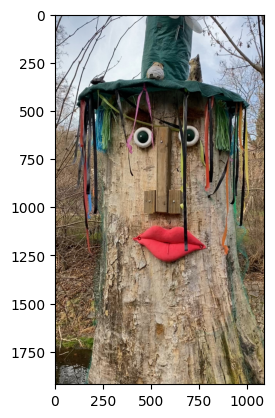

In [7]:
dirname = 'wooden_lady_subset'
img_fnames = [os.path.join(dirname, x) for x in os.listdir(dirname) if '.jpg' in x]
plt.imshow(cv2.cvtColor(cv2.imread(img_fnames[0]), cv2.COLOR_BGR2RGB))

## LoFTR Matching

In [8]:


def get_unique_idxs(A, dim=1):
    # https://stackoverflow.com/questions/72001505/how-to-get-unique-elements-and-their-firstly-appeared-indices-of-a-pytorch-tenso
    unique, idx, counts = torch.unique(A, dim=dim, sorted=True, return_inverse=True, return_counts=True)
    _, ind_sorted = torch.sort(idx, stable=True)
    cum_sum = counts.cumsum(0)
    cum_sum = torch.cat((torch.tensor([0],device=cum_sum.device), cum_sum[:-1]))
    first_indicies = ind_sorted[cum_sum]
    return first_indicies

def match_features(img_fnames,
                   index_pairs,
                   feature_dir = '.featureout_loftr',
                   device=torch.device('cpu'),
                   min_matches=15, resize_to_ = (640, 480)):
    matcher = KF.LoFTR(pretrained='outdoor').to(device).eval()
    # First we do pairwise matching, and then extract "keypoints" from loftr matches

    with h5py.File(f'{feature_dir}/matches_loftr.h5', mode='w') as f_match:
        for pair_idx in progress_bar(index_pairs):
            idx1, idx2 = pair_idx
            fname1, fname2 = img_fnames[idx1], img_fnames[idx2]
            key1, key2 = fname1.split('/')[-1], fname2.split('/')[-1]
            # Load img1
            timg1 = K.color.rgb_to_grayscale(load_torch_image(fname1, device=device))
            H1, W1 = timg1.shape[2:]
            if H1 < W1:
                resize_to = resize_to_[1], resize_to_[0]
            else:
                resize_to = resize_to_
            timg_resized1 = K.geometry.resize(timg1, resize_to, antialias=True)
            h1, w1 = timg_resized1.shape[2:]

            # Load img2
            timg2 = K.color.rgb_to_grayscale(load_torch_image(fname2, device=device))
            H2, W2 = timg2.shape[2:]
            if H2 < W2:
                resize_to2 = resize_to[1], resize_to[0]
            else:
                resize_to2 = resize_to_
            timg_resized2 = K.geometry.resize(timg2, resize_to2, antialias=True)
            h2, w2 = timg_resized2.shape[2:]
            with torch.inference_mode():
                input_dict = {"image0": timg_resized1,"image1": timg_resized2}
                correspondences = matcher(input_dict)
            mkpts0 = correspondences['keypoints0'].cpu().numpy()
            mkpts1 = correspondences['keypoints1'].cpu().numpy()

            mkpts0[:,0] *= float(W1) / float(w1)
            mkpts0[:,1] *= float(H1) / float(h1)

            mkpts1[:,0] *= float(W2) / float(w2)
            mkpts1[:,1] *= float(H2) / float(h2)

            n_matches = len(mkpts1)
            group  = f_match.require_group(key1)
            if n_matches >= min_matches:
                 group.create_dataset(key2, data=np.concatenate([mkpts0, mkpts1], axis=1))
    # Let's find unique loftr pixels and group them together
    kpts = defaultdict(list)
    match_indexes = defaultdict(dict)
    total_kpts=defaultdict(int)
    with h5py.File(f'{feature_dir}/matches_loftr.h5', mode='r') as f_match:
        for k1 in f_match.keys():
            group  = f_match[k1]
            for k2 in group.keys():
                matches = group[k2][...]
                total_kpts[k1]
                kpts[k1].append(matches[:, :2])
                kpts[k2].append(matches[:, 2:])
                current_match = torch.arange(len(matches)).reshape(-1, 1).repeat(1, 2)
                current_match[:, 0]+=total_kpts[k1]
                current_match[:, 1]+=total_kpts[k2]
                total_kpts[k1]+=len(matches)
                total_kpts[k2]+=len(matches)
                match_indexes[k1][k2]=current_match
    for k in kpts.keys():
        kpts[k] = np.round(np.concatenate(kpts[k], axis=0))
    unique_kpts = {}
    unique_match_idxs = {}
    out_match = defaultdict(dict)
    for k in kpts.keys():
        uniq_kps, uniq_reverse_idxs = torch.unique(torch.from_numpy(kpts[k]),dim=0, return_inverse=True)
        unique_match_idxs[k] = uniq_reverse_idxs
        unique_kpts[k] = uniq_kps.numpy()
    for k1, group in match_indexes.items():
        for k2, m in group.items():
            m2 = deepcopy(m)
            m2[:,0] = unique_match_idxs[k1][m2[:,0]]
            m2[:,1] = unique_match_idxs[k2][m2[:,1]]
            mkpts = np.concatenate([unique_kpts[k1][ m2[:,0]],
                                    unique_kpts[k2][  m2[:,1]],
                                   ],
                                   axis=1)
            unique_idxs_current = get_unique_idxs(torch.from_numpy(mkpts), dim=0)
            m2_semiclean = m2[unique_idxs_current]
            unique_idxs_current1 = get_unique_idxs(m2_semiclean[:, 0], dim=0)
            m2_semiclean = m2_semiclean[unique_idxs_current1]
            unique_idxs_current2 = get_unique_idxs(m2_semiclean[:, 1], dim=0)
            m2_semiclean2 = m2_semiclean[unique_idxs_current2]
            out_match[k1][k2] = m2_semiclean2.numpy()
    with h5py.File(f'{feature_dir}/keypoints.h5', mode='w') as f_kp:
        for k, kpts1 in unique_kpts.items():
            f_kp[k] = kpts1
    
    with h5py.File(f'{feature_dir}/matches.h5', mode='w') as f_match:
        for k1, gr in out_match.items():
            group  = f_match.require_group(k1)
            for k2, match in gr.items():
                group[k2] = match
    return

                    

In [9]:
# matching all to all
index_pairs = []
for i in range(len(img_fnames)):
    for j in range(i+1, len(img_fnames)):
        index_pairs.append((i,j))


In [10]:
feature_dir = '.featureout_loftr'
dev=torch.device('mps')
dev=torch.device('cpu')
match_features(img_fnames, index_pairs, feature_dir = feature_dir, device=dev)

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:4702: UserWarning: The operator 'aten::im2col' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:12.)
  return torch._C._nn.im2col(input, _pair(kernel_size), _pair(dilation), _pair(padding), _pair(stride))


## Import into colmap and run reconstruction

In [11]:
from h5_to_db import add_keypoints, add_matches, COLMAPDatabase

def import_into_colmap(img_dir,
                       feature_dir ='.featureout',
                       database_path = 'colmap.db',
                       img_ext='.jpg'):
    db = COLMAPDatabase.connect(database_path)
    db.create_tables()
    single_camera = False
    fname_to_id = add_keypoints(db, feature_dir, img_dir, img_ext, 'simple-radial', single_camera)
    add_matches(
        db,
        feature_dir,
        fname_to_id,
    )

    db.commit()
    return

database_path = 'colmap_loftr.db'
!rm {database_path}
import_into_colmap(dirname,feature_dir=feature_dir, database_path=database_path)

rm: colmap_loftr.db: No such file or directory


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 1100.05it/s]
253it [00:00, 6356.60it/s]                                                                                                                                              


In [12]:
output_path = 'colmap_rec_loftr'


In [13]:

def run_reconstruction(image_dir, output_path = 'colmap_rec', database_path = 'colmap.db'):
    pycolmap.match_exhaustive(database_path)
    maps = pycolmap.incremental_mapping(database_path, dirname, output_path)
    if not os.path.isdir(output_path):
        os.makedirs(output_path)
    maps[0].write(output_path)
    return maps

In [14]:
maps = run_reconstruction(dirname, output_path, database_path)


Exhaustive feature matching

Matching block [1/1, 1/1] in 2.161s
Elapsed time: 0.036 [minutes]

Loading database

Loading cameras... 23 in 0.000s
Loading matches... 253 in 0.001s
Loading images... 23 in 0.004s (connected 23)
Building correspondence graph... in 0.015s (ignored 0)

Elapsed time: 0.000 [minutes]


Finding good initial image pair


Initializing with image pair #12 and #10


Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.754143e+03    0.00e+00    5.94e+04   0.00e+00   0.00e+00  1.00e+04        0    9.31e-04    4.50e-03
   1  1.087009e+03    6.67e+02    6.38e+04   7.79e+01   9.33e-01  2.87e+04        1    2.84e-03    7.36e-03
   2  9.684136e+02    1.19e+02    2.65e+04   6.80e+01   8.70e-01  4.82e+04        1    1.80e-03    9.17e-03
   3  9.422900e+02    2.61e+01    8.50e+03   2.73e+01   9.63e-01  1.45e+05        1    1.80e-03    1.10e-02
   4  9.441497e+02   -1.86e+00    8.50e+03 


Bundle adjustment report
------------------------
    Residuals : 10394
   Parameters : 5972
   Iterations : 21
         Time : 0.0697091 [s]
 Initial cost : 0.532753 [px]
   Final cost : 0.448464 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 5
  => Filtered observations: 94
  => Changed observations: 0.019049

Bundle adjustment report
------------------------
    Residuals : 10216
   Parameters : 5939
   Iterations : 7
         Time : 0.0252721 [s]
 Initial cost : 0.47029 [px]
   Final cost : 0.454214 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 20
  => Filtered observations: 0
  => Changed observations: 0.003915

Retriangulation

  => Completed observations: 0
  => Merged observations: 0
  => Retriangulated observations: 0

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  2.154999e+03    0.00e+00    1.06


Pose refinement report
----------------------
    Residuals : 3664
   Parameters : 8
   Iterations : 20
         Time : 0.0155768 [s]
 Initial cost : 0.630936 [px]
   Final cost : 0.558821 [px]
  Termination : Convergence

  => Continued observations: 1829
  => Added observations: 3875

Bundle adjustment report
------------------------
    Residuals : 38504
   Parameters : 18566
   Iterations : 26
         Time : 0.453691 [s]
 Initial cost : 0.525545 [px]
   Final cost : 0.489619 [px]
  Termination : No convergence

  => Merged observations: 89
  => Completed observations: 146
  => Filtered observations: 306
  => Changed observations: 0.028101

Bundle adjustment report
------------------------
    Residuals : 38178
   Parameters : 18608
   Iterations : 5
         Time : 0.086839 [s]
 Initial cost : 0.548617 [px]
   Final cost : 0.531227 [px]
  Termination : Convergence

  => Merged observations: 0
  => Completed observations: 81
  => Filtered observations: 0
  => Changed observations:

   4  1.876764e+04    2.42e-02    1.20e+01   1.41e+00   1.02e+00  8.10e+05        1    2.47e-02    1.23e-01
   5  1.876764e+04    5.69e-04    1.98e+00   2.36e-01   1.03e+00  2.43e+06        1    2.35e-02    1.47e-01
   6  1.876764e+04    4.38e-06    1.69e-01   1.69e-02   1.09e+00  7.29e+06        1    2.40e-02    1.71e-01
   7  1.876764e+04    6.06e-08    2.21e-02   1.11e-03   1.16e+00  2.19e+07        1    2.21e-02    1.93e-01


Bundle adjustment report
------------------------
    Residuals : 57814
   Parameters : 24174
   Iterations : 8
         Time : 0.193287 [s]
 Initial cost : 0.571437 [px]
   Final cost : 0.569755 [px]
  Termination : Convergence

  => Completed observations: 2
  => Merged observations: 0
  => Filtered observations: 5
  => Changed observations: 0.000242
  => Filtered images: 0

Registering image #1 (9)

  => Image sees 1645 / 14268 points

Pose refinement report
----------------------
    Residuals : 3230
   Parameters : 8
   Iterations : 11
         Time : 0.0

   2  3.584707e+04    1.36e+00    1.49e+02   7.05e+00   1.00e+00  9.00e+04        1    3.91e-02    1.28e-01
   3  3.584573e+04    1.35e+00    3.69e+02   1.17e+01   9.84e-01  2.70e+05        1    3.67e-02    1.64e-01
   4  3.584519e+04    5.40e-01    2.59e+02   9.52e+00   9.80e-01  8.10e+05        1    3.72e-02    2.01e-01
   5  3.584512e+04    6.26e-02    3.33e+01   3.24e+00   1.01e+00  2.43e+06        1    3.78e-02    2.39e-01
   6  3.584512e+04    1.03e-03    1.91e+00   4.46e-01   1.02e+00  7.29e+06        1    3.73e-02    2.77e-01
   7  3.584512e+04    3.33e-06    1.14e-01   2.83e-02   1.03e+00  2.19e+07        1    3.70e-02    3.14e-01


Bundle adjustment report
------------------------
    Residuals : 95966
   Parameters : 36711
   Iterations : 8
         Time : 0.314517 [s]
 Initial cost : 0.611856 [px]
   Final cost : 0.611162 [px]
  Termination : Convergence

  => Completed observations: 0
  => Merged observations: 0
  => Filtered observations: 6
  => Changed observations: 0.00

  => Completed observations: 1
  => Merged observations: 23
  => Retriangulated observations: 0

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  7.323046e+04    0.00e+00    6.32e+04   0.00e+00   0.00e+00  1.00e+04        0    1.37e-02    9.99e-02
   1  7.303959e+04    1.91e+02    5.03e+02   7.06e+00   9.99e-01  3.00e+04        1    7.49e-02    1.75e-01
   2  7.303457e+04    5.03e+00    5.41e+02   1.01e+01   1.00e+00  9.00e+04        1    6.73e-02    2.42e-01
   3  7.303208e+04    2.48e+00    4.34e+02   1.61e+01   9.91e-01  2.70e+05        1    6.71e-02    3.09e-01
   4  7.303139e+04    6.94e-01    2.45e+02   1.34e+01   9.92e-01  8.10e+05        1    6.55e-02    3.75e-01
   5  7.303133e+04    6.11e-02    2.46e+01   4.51e+00   1.01e+00  2.43e+06        1    6.64e-02    4.41e-01
   6  7.303133e+04    8.56e-04    1.79e+00   5.81e-01   1.02e+00  7.29e+06        1    6.79e-02    5.09e-01
   7  7.30313

   5  1.135196e+05    2.48e-02    1.10e+01   4.39e+00   1.02e+00  2.43e+06        1    9.94e-02    7.21e-01
   6  1.135196e+05    7.42e-04    1.96e+00   8.24e-01   1.02e+00  7.29e+06        1    9.92e-02    8.20e-01
   7  1.135196e+05    4.67e-06    2.41e-01   6.66e-02   1.03e+00  2.19e+07        1    9.42e-02    9.14e-01


Bundle adjustment report
------------------------
    Residuals : 263684
   Parameters : 82854
   Iterations : 8
         Time : 0.916849 [s]
 Initial cost : 0.719335 [px]
   Final cost : 0.656135 [px]
  Termination : Convergence

  => Completed observations: 20
  => Merged observations: 22
  => Filtered observations: 37
  => Changed observations: 0.000599

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  1.087219e+05    0.00e+00    1.84e+04   0.00e+00   0.00e+00  1.00e+04        0    2.10e-02    1.64e-01
   1  1.086250e+05    9.68e+01    4.03e+02   5.39e+00   1.00e+00  3.00e+

  => Merged observations: 514
  => Completed observations: 187
  => Filtered observations: 6
  => Changed observations: 0.009748

Retriangulation

  => Completed observations: 3
  => Merged observations: 50
  => Retriangulated observations: 44

Global bundle adjustment

iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  3.301066e+05    0.00e+00    4.38e+05   0.00e+00   0.00e+00  1.00e+04        0    3.11e-02    2.59e-01
   1  2.460963e+05    8.40e+04    1.80e+04   3.74e+01   1.01e+00  3.00e+04        1    1.45e-01    4.04e-01
   2  2.458198e+05    2.76e+02    9.22e+02   2.12e+01   1.01e+00  9.00e+04        1    1.30e-01    5.35e-01
   3  2.458164e+05    3.42e+00    3.47e+02   1.85e+01   1.03e+00  2.70e+05        1    1.28e-01    6.63e-01
   4  2.458155e+05    8.78e-01    2.70e+02   1.48e+01   1.00e+00  8.10e+05        1    1.30e-01    7.93e-01
   5  2.458154e+05    8.82e-02    3.65e+01   5.14e+00   1.02e+00  2.43e+06       

   2  2.023095e+05    1.16e+00    2.58e+01   3.09e+00   1.02e+00  9.00e+04        1    1.65e-01    6.79e-01
   3  2.023094e+05    1.11e-01    1.20e+01   3.21e+00   1.02e+00  2.70e+05        1    1.69e-01    8.49e-01
   4  2.023094e+05    2.62e-02    5.11e+00   2.42e+00   1.01e+00  8.10e+05        1    1.60e-01    1.01e+00
   5  2.023094e+05    1.91e-03    1.95e+00   7.66e-01   1.01e+00  2.43e+06        1    1.67e-01    1.18e+00
   6  2.023094e+05    2.65e-05    7.10e-01   9.48e-02   1.02e+00  7.29e+06        1    1.71e-01    1.35e+00


Bundle adjustment report
------------------------
    Residuals : 443578
   Parameters : 121455
   Iterations : 7
         Time : 1.3514 [s]
 Initial cost : 0.675973 [px]
   Final cost : 0.675341 [px]
  Termination : Convergence

  => Completed observations: 32
  => Merged observations: 56
  => Filtered observations: 4
  => Changed observations: 0.000415
  => Filtered images: 0

Elapsed time: 0.515 [minutes]


## Visualize with colmap GUI (yes, it is cheating)

In [15]:
!colmap gui

qt.qpa.fonts: Populating font family aliases took 142 ms. Replace uses of missing font family "Courier" with one that exists to avoid this cost. 
2023-03-21 14:54:02.342 colmap[11784:2293767] +[CATransaction synchronize] called within transaction
QOpenGLVertexArrayObject::destroy() failed to restore current context


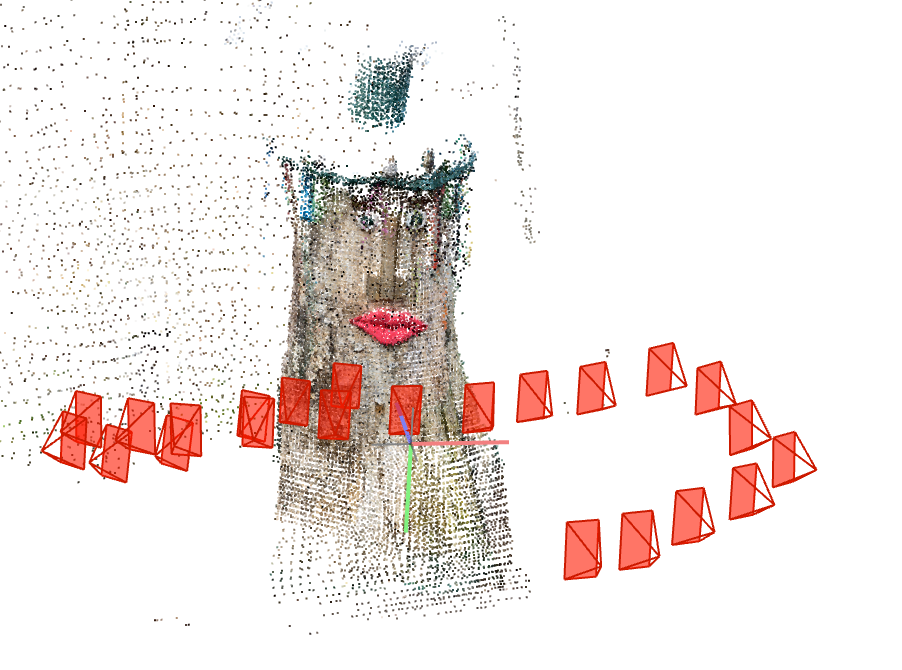